<a href="https://colab.research.google.com/github/it22258380/DL-Assignment/blob/feature%2FAkash/TCN_Akash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score


# Setup plotting
%matplotlib inline
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [3]:
#Extracting the SriLanka Weather data set
weather = pd.read_csv('/content/drive/My Drive/Deep learning assigment/SriLanka_Weather_Dataset.csv')
print("Data shape:",weather.shape)
print(weather.head(5))


Data shape: (147480, 24)
         time  weathercode  temperature_2m_max  temperature_2m_min  \
0  2010-01-01            2                30.0                22.7   
1  2010-01-02           51                29.9                23.5   
2  2010-01-03           51                29.5                23.2   
3  2010-01-04            2                28.9                21.9   
4  2010-01-05            1                28.1                21.3   

   temperature_2m_mean  apparent_temperature_max  apparent_temperature_min  \
0                 26.1                      34.4                      25.2   
1                 26.2                      33.8                      26.2   
2                 26.0                      34.3                      26.3   
3                 25.3                      31.6                      23.4   
4                 24.5                      30.1                      23.1   

   apparent_temperature_mean           sunrise            sunset  ...  \
0           

In [4]:
#clean rows with missing values
weather = weather.dropna()
weather = weather.reset_index(drop=True)
print("Data shape:",weather.shape)#after cleaning


Data shape: (147480, 24)


In [5]:
# Drop columns that are not numeric
drop_cols = ['city', 'country', 'latitude', 'longitude', 'elevation', 'time', 'sunrise', 'sunset']
data = weather.drop(columns=drop_cols, errors='ignore')

# Select only numeric columns
data = data.select_dtypes(include=[np.number])

print("Columns used for training:")
print(list(data.columns))



Columns used for training:
['weathercode', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant', 'et0_fao_evapotranspiration']


In [6]:
# Choose temperature_2m_mean as target variable
target_col = 'temperature_2m_mean'
if target_col not in data.columns:
    raise ValueError(f"{target_col} not found in dataset")

X = data.drop(columns=[target_col])
y = data[target_col]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

# Function to convert to sequential format for TCN
timesteps = 10  # use past 10 days to predict next day

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps)])
        ys.append(y.iloc[i + timesteps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

print("Training shape:", X_train_seq.shape, y_train_seq.shape)
print("Testing shape:", X_test_seq.shape, y_test_seq.shape)


Training shape: (117974, 10, 15) (117974,)
Testing shape: (29486, 10, 15) (29486,)


In [9]:
!pip install keras-tcn -q

In [10]:
#Build TCN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN

model = Sequential([
    TCN(
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
        nb_filters=64,
        kernel_size=3,
        nb_stacks=1,
        dilations=[1, 2, 4, 8, 16],
        dropout_rate=0.2,
        return_sequences=False,
        activation='relu'
    ),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       115,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,361 (466.25 KB)

 Trainable params: 119,361 (466.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Training ---
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

#save the model for future works
model.save("tcn_model.keras")



Epoch 1/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 111s 30ms/step - loss: 0.2167 - mae: 0.3626 - val_loss: 0.2662 - val_mae: 0.4023
Epoch 2/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 103s 28ms/step - loss: 0.2212 - mae: 0.3656 - val_loss: 0.2796 - val_mae: 0.4125
Epoch 3/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 0.2185 - mae: 0.3641 - val_loss: 0.2573 - val_mae: 0.3993
Epoch 4/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 149s 30ms/step - loss: 0.2168 - mae: 0.3622 - val_loss: 0.2830 - val_mae: 0.4250
Epoch 5/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 104s 28ms/step - loss: 0.2206 - mae: 0.3638 - val_loss: 0.2996 - val_mae: 0.4405
Epoch 6/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 106s 29ms/step - loss: 0.2160 - mae: 0.3625 - val_loss: 0.3241 - val_mae: 0.4616
Epoch 7/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 103s 28ms/step - loss: 0.2147 - mae: 0.3617 - val_loss: 0.2979 - val_mae: 0.4388
Epoch 8/50
3687/3687 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - loss: 0.2145 - mae: 0.3608 - val_loss: 0.2935 - val_mae: 0.4238
Epoch 9/50
3687/

In [ ]:
loss, mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# --- Predictions ---
y_pred = model.predict(X_test_seq)
print("R^2 Score:", r2_score(y_test_seq, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_seq, y_pred)))

Test Loss: 0.2474
Test MAE: 0.3916
922/922 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
R^2 Score: 0.9612599087339445
RMSE: 0.49740099280514616


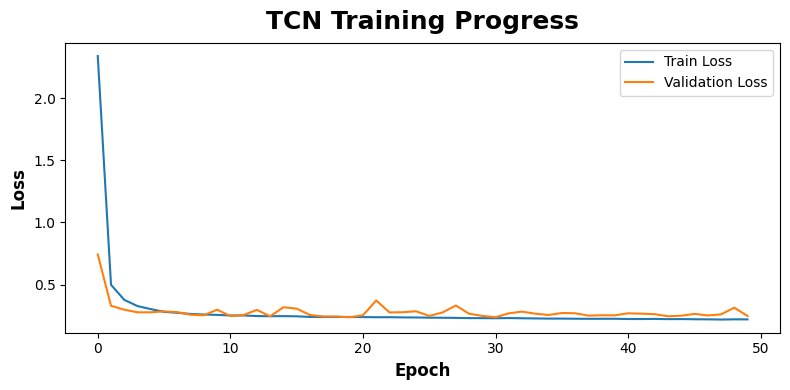

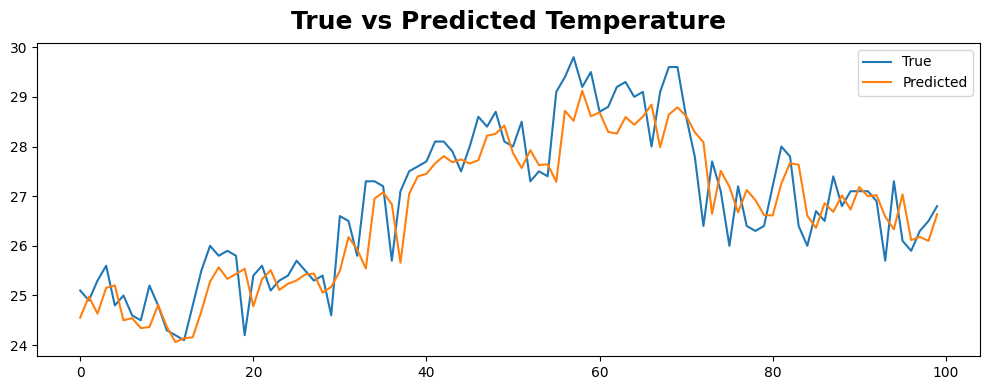

In [ ]:
# visualization

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TCN Training Progress')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_test_seq[:100], label='True')
plt.plot(y_pred[:100], label='Predicted')
plt.title('True vs Predicted Temperature')
plt.legend()
plt.show()